In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time

In [2]:
data = pd.read_csv('../data/train_clean.csv')

In [3]:
#train_test_split

train_breath_ids, test_breath_ids = train_test_split(data['breath_id'].unique() , test_size=0.25, random_state=42)

train = data[data['breath_id'].isin(train_breath_ids)]
test = data[data['breath_id'].isin(test_breath_ids)]

assert(data.shape[0] == train.shape[0] + test.shape[0])

In [4]:
# each breath is a time series, will use two lags as features for each breath

In [5]:
# means, rolling means of u_in

In [6]:
# u_in*time to get an 'area'

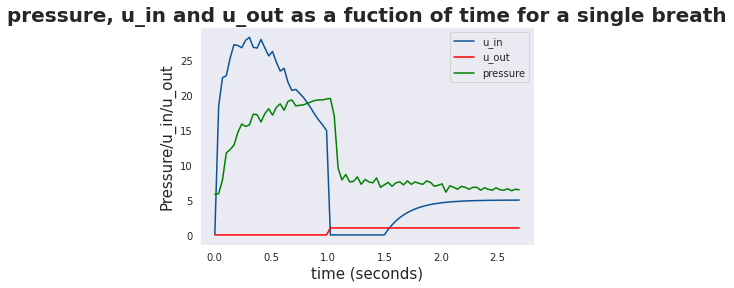

In [7]:
# looking at a single breath

breath_id = 1
train[train['breath_id'] == breath_id]

#Plot u_in and u_out as a function of time for a single breath

fig, ax = plt.subplots()

sns.lineplot(y = train[train['breath_id'] == breath_id]['u_in'], x = train[train['breath_id'] == breath_id]['time_step'], 
             ax = ax, alpha = 1, color = myblue, label = 'u_in');
sns.lineplot(y = train[train['breath_id'] == breath_id]['u_out'], x = train[train['breath_id'] == breath_id]['time_step'], 
             ax = ax, alpha = 1, color = 'red', label = 'u_out');
sns.lineplot(y = train[train['breath_id'] == breath_id]['pressure'], x = train[train['breath_id'] == breath_id]['time_step'], 
             ax = ax, alpha = 1, color = 'green', label = 'pressure');

plt.title('pressure, u_in and u_out as a fuction of time for a single breath', fontweight = 'bold');
plt.xlabel('time (seconds)');
plt.ylabel('Pressure/u_in/u_out');


In [8]:
#creating breath level features

single_breath_df = train[train['breath_id'] == breath_id].copy()
single_breath_df['u_in_lag_1'] = single_breath_df['u_in'].shift(1).fillna(0)
single_breath_df['u_in_lag_2'] = single_breath_df['u_in'].shift(2).fillna(0)
single_breath_df['step_duration'] = single_breath_df['time_step'].diff(1).fillna(0)
single_breath_df['mean_u_in'] = single_breath_df['u_in'].mean()

#can tune the rolling mean/sum windows
single_breath_df['u_in_rolling_mean'] = single_breath_df['u_in'].rolling(2).mean().fillna(0)
single_breath_df['u_in_rolling_sum'] = single_breath_df['u_in'].rolling(2).sum().fillna(0)
single_breath_df['u_in_cum_sum'] = single_breath_df['u_in'].cumsum()
single_breath_df['u_out_rolling_mean'] = single_breath_df['u_out'].rolling(2).mean().fillna(0)
single_breath_df['u_out_rolling_sum'] = single_breath_df['u_out'].rolling(2).sum().fillna(0)
single_breath_df['u_out_cum_sum'] = single_breath_df['u_out'].cumsum()



#polynomial features
#can tune the powers
single_breath_df['u_in_x_time_step'] = single_breath_df['u_in']*single_breath_df['time_step']
single_breath_df['R_x_C'] = single_breath_df['R']*single_breath_df['C']

#can create rolling means and sums and cumsums of the polynomial features

single_breath_df


,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,step_duration,mean_u_in,u_in_rolling_mean,u_in_rolling_sum,u_in_cum_sum,u_out_rolling_mean,u_out_rolling_sum,u_out_cum_sum,u_in_x_time_step,R_x_C
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.000000,10.146007,0.000000,0.000000,0.083334,0.0,0.0,0,0.000000,1000
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.083334,0.000000,0.033652,10.146007,9.233188,18.466375,18.466375,0.0,0.0,0,0.618632,1000
2,3,1,20,50,0.067514,22.509278,0,7.876254,18.383041,0.083334,0.033862,10.146007,20.446160,40.892319,40.975653,0.0,0.0,0,1.519701,1000
3,4,1,20,50,0.101542,22.808822,0,11.742872,22.509278,18.383041,0.034028,10.146007,22.659050,45.318100,63.784476,0.0,0.0,0,2.316059,1000
4,5,1,20,50,0.135756,25.355850,0,12.234987,22.808822,22.509278,0.034213,10.146007,24.082336,48.164673,89.140326,0.0,0.0,0,3.442197,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,76,1,20,50,2.553593,4.974474,1,6.399909,4.969730,4.964136,0.034092,10.146007,4.972102,9.944203,791.748433,1.0,2.0,46,12.702783,1000
76,77,1,20,50,2.587754,4.978481,1,6.610815,4.974474,4.969730,0.034160,10.146007,4.976478,9.952955,796.726915,1.0,2.0,47,12.883083,1000
77,78,1,20,50,2.621773,4.981847,1,6.329607,4.978481,4.974474,0.034020,10.146007,4.980164,9.960329,801.708762,1.0,2.0,48,13.061275,1000
78,79,1,20,50,2.655746,4.984683,1,6.540513,4.981847,4.978481,0.033972,10.146007,4.983265,9.966531,806.693445,1.0,2.0,49,13.238051,1000


In [9]:
def create_breath_level_features(data, breath_id):
    
    '''takes the breath id and the given ventilator data and returns a number of breath level features'''
    
    single_breath_df = data[data['breath_id'] == breath_id].copy()
    
    single_breath_df['u_in_lag_1'] = single_breath_df['u_in'].shift(1).fillna(0)
    single_breath_df['u_in_lag_2'] = single_breath_df['u_in'].shift(2).fillna(0)
    single_breath_df['step_duration'] = single_breath_df['time_step'].diff(1).fillna(0)
    single_breath_df['mean_u_in'] = single_breath_df['u_in'].mean()

    #can tune the rolling mean/sum windows
    single_breath_df['u_in_rolling_mean'] = single_breath_df['u_in'].rolling(2).mean().fillna(0)
    single_breath_df['u_in_rolling_sum'] = single_breath_df['u_in'].rolling(2).sum().fillna(0)
    single_breath_df['u_in_cum_sum'] = single_breath_df['u_in'].cumsum()
    single_breath_df['u_out_rolling_mean'] = single_breath_df['u_out'].rolling(2).mean().fillna(0)
    single_breath_df['u_out_rolling_sum'] = single_breath_df['u_out'].rolling(2).sum().fillna(0)
    single_breath_df['u_out_cum_sum'] = single_breath_df['u_out'].cumsum()



    #polynomial features
    #can tune the powers
    single_breath_df['u_in_x_time_step'] = single_breath_df['u_in']*single_breath_df['time_step']
    single_breath_df['R_x_C'] = single_breath_df['R']*single_breath_df['C']
    
    return(single_breath_df)    

In [10]:
# creating a new DataFrame with the breath level features

data_with_features = pd.concat([create_breath_level_features(data, i) for i in data['breath_id'].unique()])

In [11]:
data_with_features.head()
data_with_features.shape
data.shape
data_with_features['breath_id'].unique().shape
data['breath_id'].unique().shape

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,step_duration,mean_u_in,u_in_rolling_mean,u_in_rolling_sum,u_in_cum_sum,u_out_rolling_mean,u_out_rolling_sum,u_out_cum_sum,u_in_x_time_step,R_x_C
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.000000,10.146007,0.000000,0.000000,0.083334,0.0,0.0,0,0.000000,1000
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.083334,0.000000,0.033652,10.146007,9.233188,18.466375,18.466375,0.0,0.0,0,0.618632,1000
2,3,1,20,50,0.067514,22.509278,0,7.876254,18.383041,0.083334,0.033862,10.146007,20.446160,40.892319,40.975653,0.0,0.0,0,1.519701,1000
3,4,1,20,50,0.101542,22.808822,0,11.742872,22.509278,18.383041,0.034028,10.146007,22.659050,45.318100,63.784476,0.0,0.0,0,2.316059,1000
4,5,1,20,50,0.135756,25.355850,0,12.234987,22.808822,22.509278,0.034213,10.146007,24.082336,48.164673,89.140326,0.0,0.0,0,3.442197,1000


(4522560, 20)

(4522560, 8)

(56532,)

(56532,)

In [12]:
#exporting the features DataFrame

# data_with_features.to_csv('../data/data_with_features_v1.csv', index=False)

In [13]:
data_with_features.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'u_in_lag_1', 'u_in_lag_2', 'step_duration', 'mean_u_in',
       'u_in_rolling_mean', 'u_in_rolling_sum', 'u_in_cum_sum',
       'u_out_rolling_mean', 'u_out_rolling_sum', 'u_out_cum_sum',
       'u_in_x_time_step', 'R_x_C'],
      dtype='object')

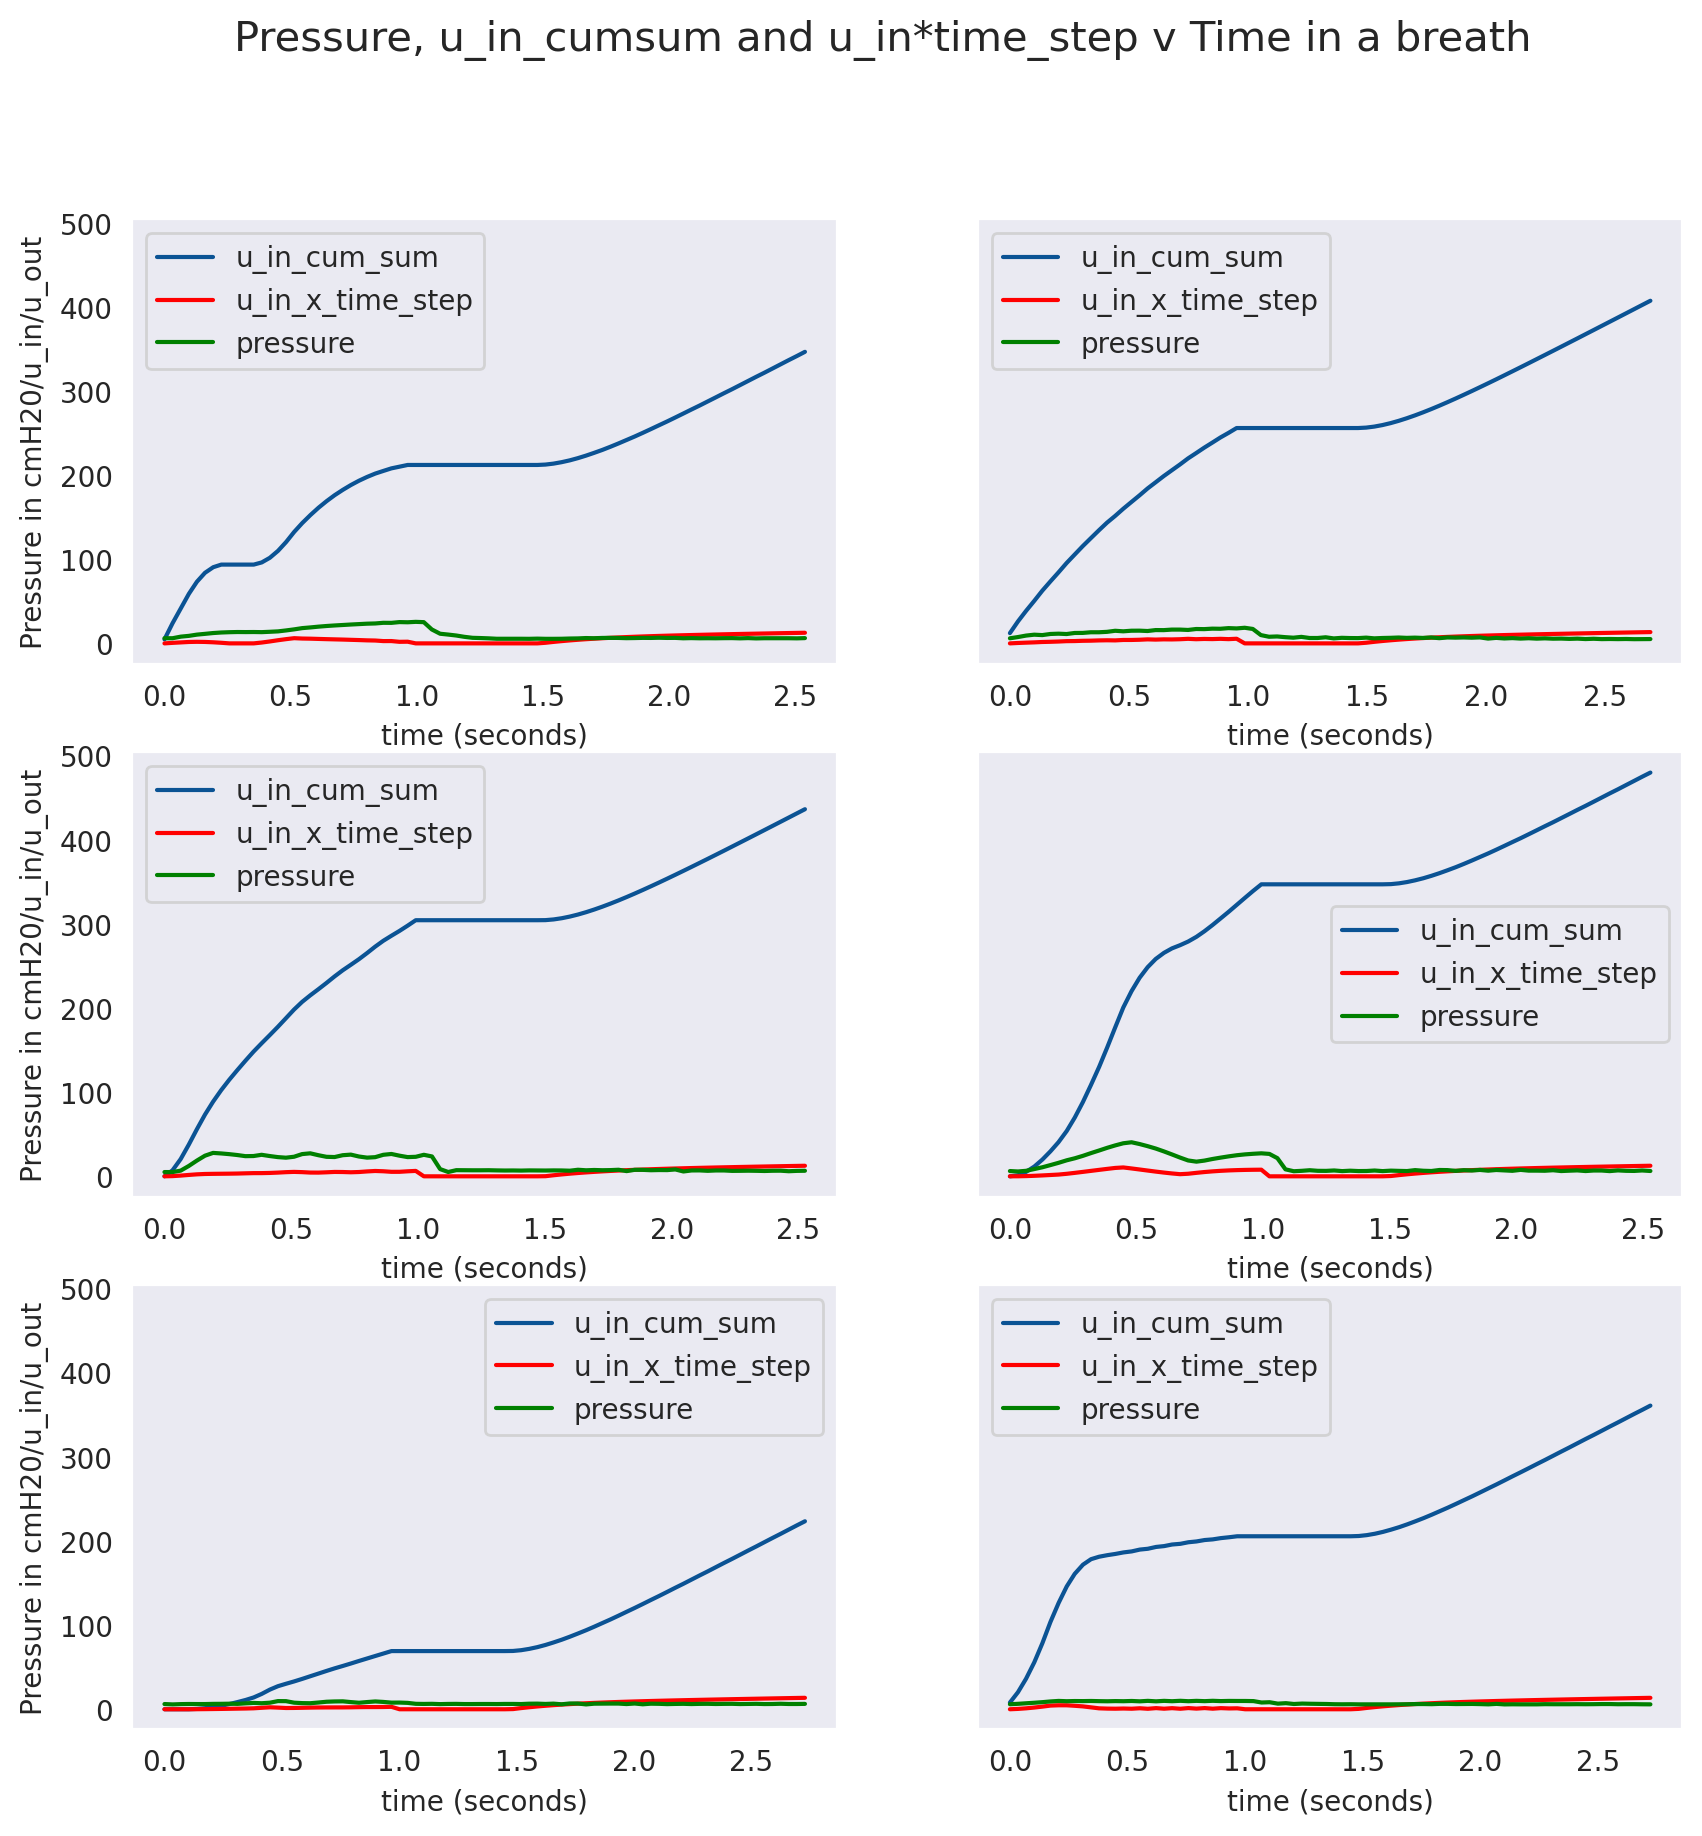

In [16]:
#visualizations of engineered features

#Plot u_in and u_out as a function of time for a smaple of six breath

fig, ax = plt.subplots(3, 2, dpi=200, figsize=(10,10), sharey=True );

breath_ids = [100,2,3,4,20,6] 

for i, breath_id in enumerate(breath_ids):
    
    sns.lineplot(y = data_with_features[data_with_features['breath_id'] == breath_id]['u_in_cum_sum'], x = data_with_features[data_with_features['breath_id'] == breath_id]['time_step'], 
                 ax = ax[i%len(breath_ids)//2, i%2], alpha = 1, color = myblue, label ='u_in_cum_sum');
    sns.lineplot(y = data_with_features[data_with_features['breath_id'] == breath_id]['u_in_x_time_step'], x = data_with_features[data_with_features['breath_id'] == breath_id]['time_step'], 
                 ax = ax[i%len(breath_ids)//2, i%2], alpha = 1, color = 'red', label='u_in_x_time_step');
    sns.lineplot(y = data_with_features[data_with_features['breath_id'] == breath_id]['pressure'], x = data_with_features[data_with_features['breath_id'] == breath_id]['time_step'], 
                 ax = ax[i%len(breath_ids)//2, i%2], alpha = 1, color = 'green', label='pressure');
    ax[i%len(breath_ids)//2, i%2].set_xlabel('time (seconds)', fontsize=10);
    ax[i%len(breath_ids)//2, i%2].set_ylabel('Pressure in cmH20/u_in/u_out', fontsize=10);
  
fig.suptitle('Pressure, u_in_cumsum and u_in*time_step v Time in a breath', fontsize=15, fontweight=10);

In [2]:
data = pd.read_csv('../data/train_clean.csv')

In [3]:
data_with_features = pd.read_csv('../data/data_with_features_v1.csv')

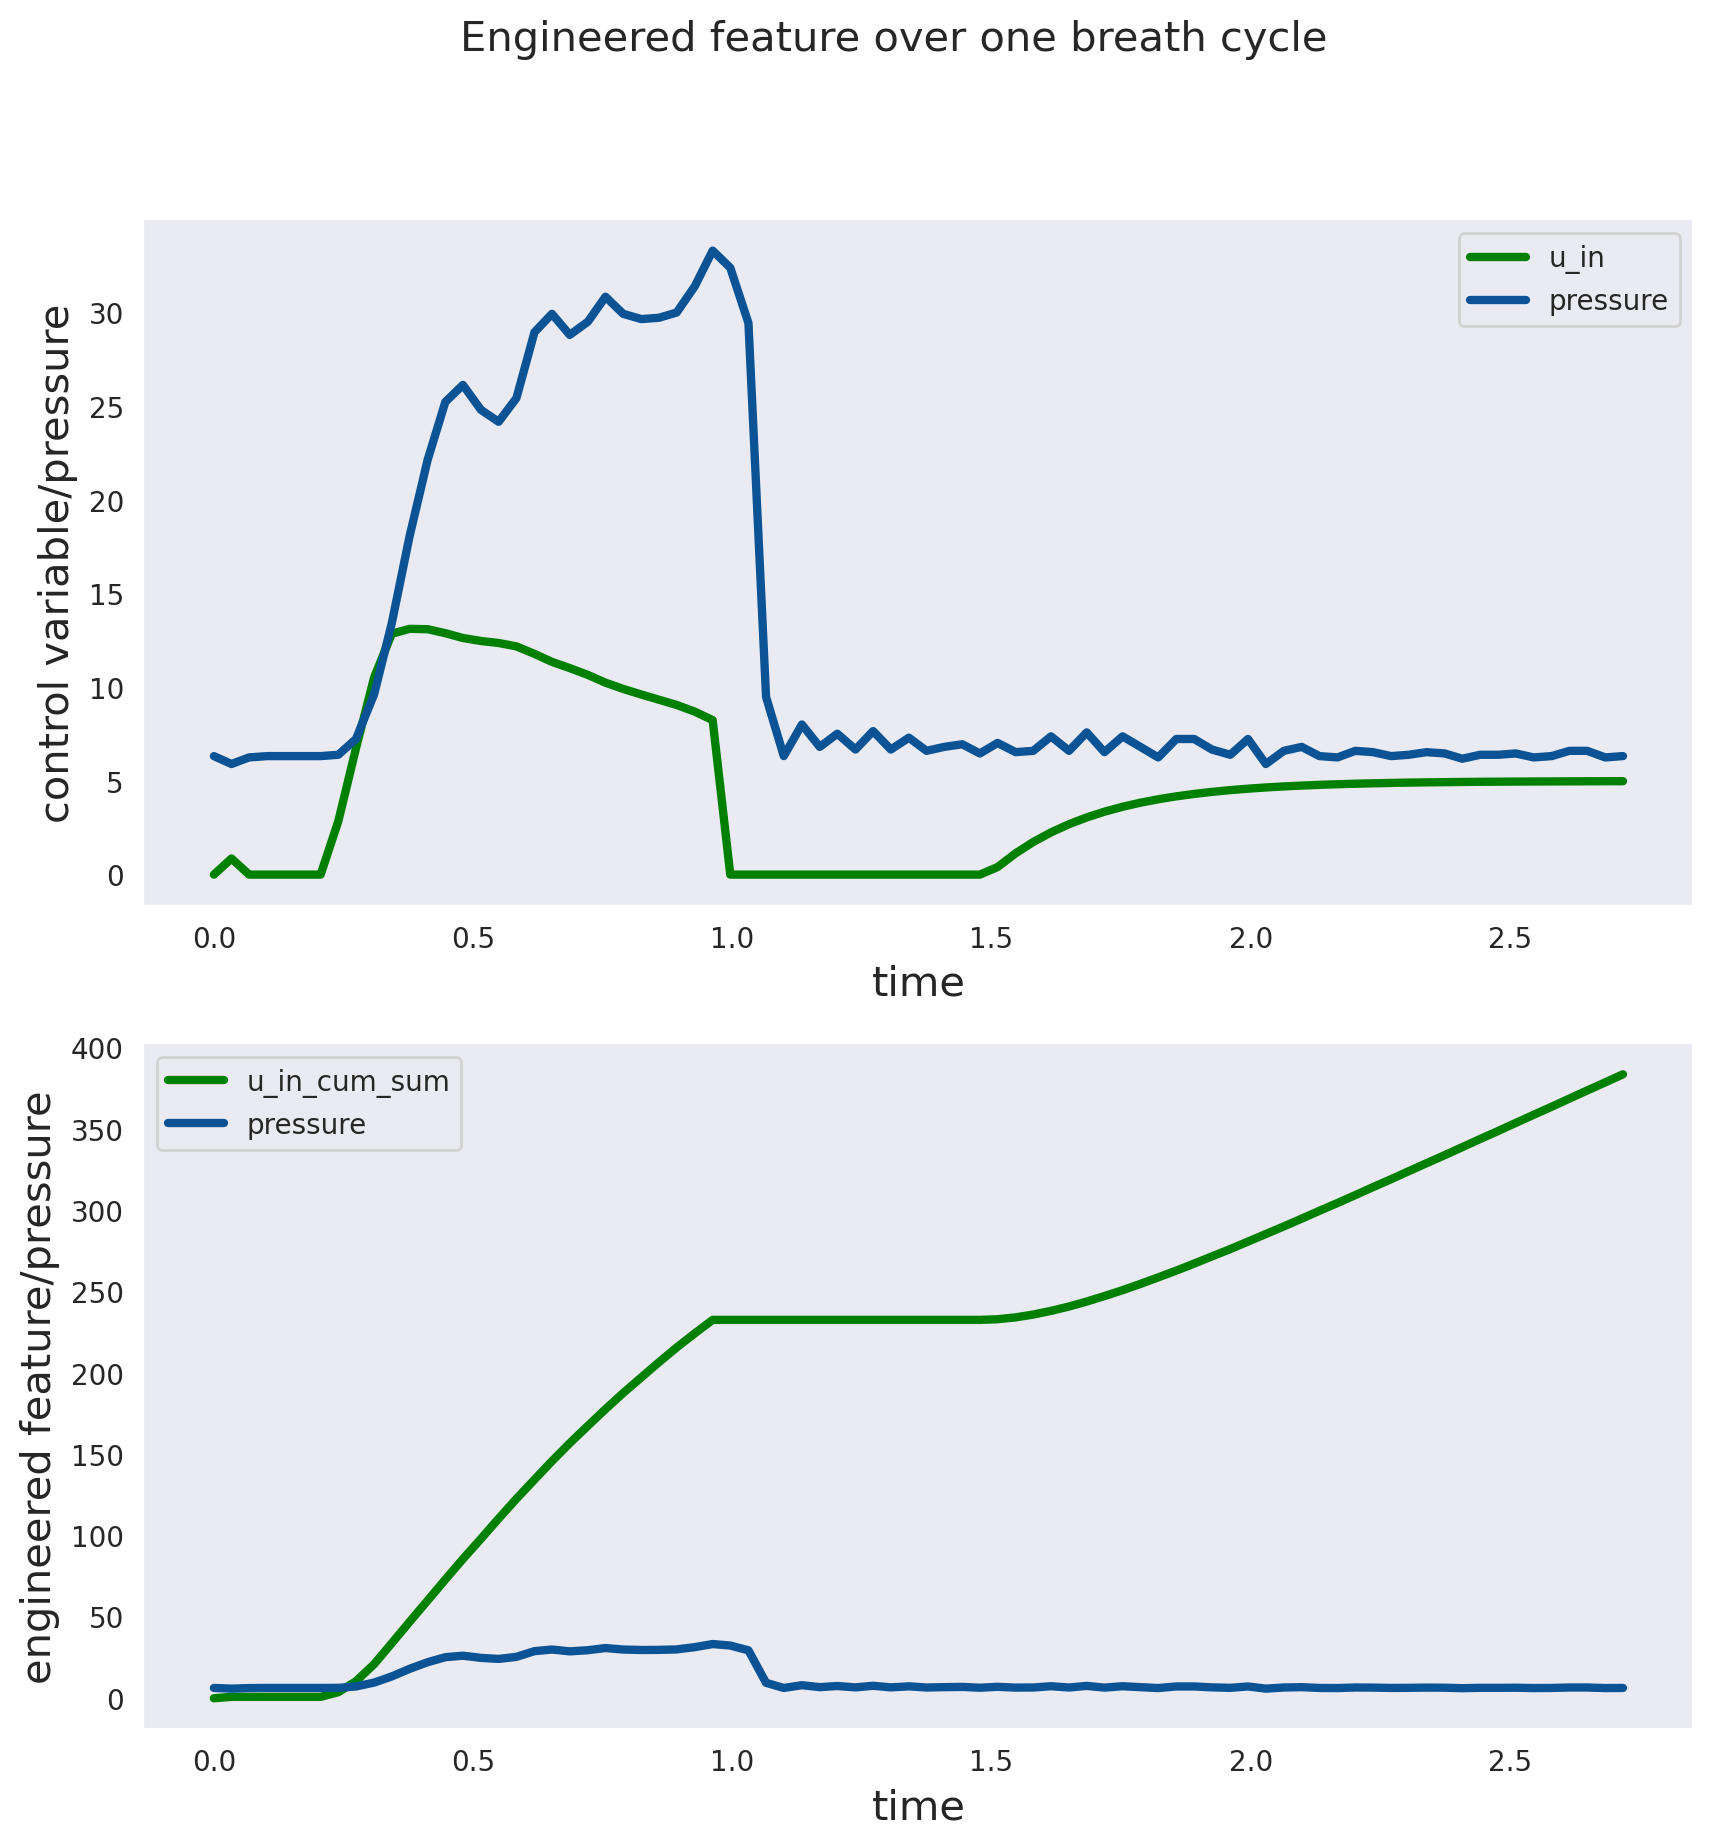

In [12]:
#Plot u_in and u_out as a function of time for a single breath

fig, ax = plt.subplots(2,1, figsize = (10,10), dpi=200);
breath_id = 40

sns.lineplot(y = data[data['breath_id'] == breath_id]['u_in'], x = data[data['breath_id'] == breath_id]['time_step'], 
             ax = ax[0], alpha = 1, color = 'green',   label = 'u_in', linewidth=3);

sns.lineplot(y = data[data['breath_id'] == breath_id]['pressure'], x = data[data['breath_id'] == breath_id]['time_step'], 
             ax = ax[0], alpha = 1, color = myblue, label = 'pressure', linewidth=3);

sns.lineplot(y = data_with_features[data_with_features['breath_id'] == breath_id]['u_in_cum_sum'], x = data_with_features[data_with_features['breath_id'] == breath_id]['time_step'], 
             ax = ax[1], alpha = 1, color = 'green', label = 'u_in_cum_sum', linewidth=3);

sns.lineplot(y = data_with_features[data_with_features['breath_id'] == breath_id]['pressure'], x = data_with_features[data_with_features['breath_id'] == breath_id]['time_step'], 
             ax = ax[1], alpha = 1, color = myblue, label = 'pressure', linewidth=3);

ax[0].set_ylabel('control variable/pressure');
ax[1].set_ylabel('engineered feature/pressure');
ax[0].set_xlabel('time');
ax[1].set_xlabel('time');
fig.suptitle('Engineered feature over one breath cycle', fontsize=15);